In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class transform_data:
    def __init__(self, path):
        self.path = path

    def get_data(self, train_or_analysis = 'train'):
        # Load data
        train_df = pd.read_csv(self.path)

        # Calculate percentage of null values in columns
        def pct_null_column(df):
            nulls = {}
            for column in df.columns:
                l = len(df)
                null = (df[column].isna()).sum()
                pct_null = (null / l) * 100
                nulls[column] = pct_null
            df = pd.DataFrame(index = ['pct_null_values'], data = nulls).T.sort_values(by = 'pct_null_values', ascending=False)
            return df.loc[(df.pct_null_values != 0)]

        nulls = pct_null_column(train_df.copy())

        # Fill null values
        def fill_nas(df):
            for column in df.columns:
                if column == 'PoolQC':
                    df[column] = df[column].fillna('No Pool')
                elif column == 'MiscFeature':
                    df[column] = df[column].fillna('No Misc')
                elif column == 'Alley':
                    df[column] = df[column].fillna('No Alley')
                elif column == 'Fence':
                    df[column] = df[column].fillna('No Fence')
                elif column == 'FireplaceQu':
                    df[column] = df[column].fillna('No Fireplace')
                elif column == 'GarageYrBlt':
                    df[column] = df[column].fillna(0)
                elif column in ('GarageCond', 'GarageType', 'GarageFinish', 'GarageQual'):
                    df[column] = df[column].fillna('No Garage')
                elif column in ('BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1'):
                    df[column] = df[column].fillna('No Basement')
                elif column == 'LotFrontage':
                    df[column] = df[column].fillna(df[column].mean())
            #df.dropna(inplace = True)
            return df

        train_df = fill_nas(train_df)
        ## For analysis is better to have categorical columns instead of onehot encoded
        if train_or_analysis == 'analysis':
            return train_df
        # Log-transform numerical columns
        num_columns = []
        for column in train_df.columns:
            if train_df[column].dtype in ('int64', 'float64'):
                num_columns.append(column)

        #for column in num_columns:
        #    if train_df[column].min() == 0:
        #       train_df[column] = np.log(train_df[column].astype(float) + 1)
        #    elif column == 'Id':
        #        continue
        #    else:
        #        train_df[column] = np.log(train_df[column].astype(float))

        # One-hot encode categorical columns
        cat_columns = [column for column in train_df.columns if train_df[column].dtype == 'O']

        train_cat = pd.DataFrame()
        encoder = OneHotEncoder()
        for i in cat_columns:
            cat = pd.DataFrame(data = encoder.fit_transform(train_df[[i]]).toarray(), columns = encoder.get_feature_names_out())
            if i == 'MSZoning':
                train_cat = cat
            else:
                train_cat = train_cat.join(cat)

        train_df.drop(cat_columns, axis = 1, inplace = True)
        train_cat.reset_index(drop = True, inplace = True)
        train_df.reset_index(drop = True, inplace = True)

        # Join transformed columns
        train_df = train_df.join(train_cat)

        return train_df

In [3]:
path = r"./"
data_generator = transform_data(path = path + 'train.csv')
data = data_generator.get_data(train_or_analysis = 'train')
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


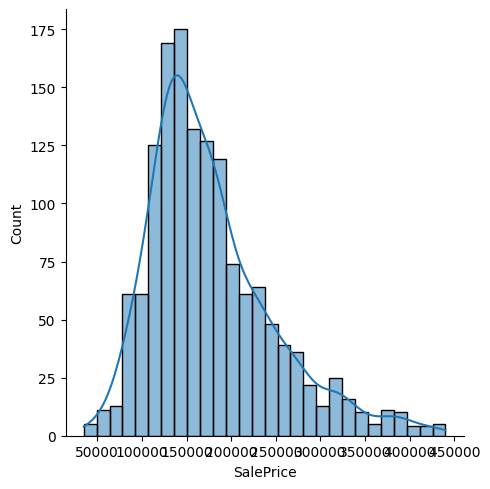

In [4]:
data = data.loc[data['SalePrice'] <= np.quantile(data['SalePrice'], 0.99)].copy()
sns.displot(data.SalePrice, kde = True);

In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score


params = {'lambda': 3.792404253903758, 'alpha': 3.720406654006611, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.027569142191457396, 'max_depth': 7, 'random_state': 1, 'min_child_weight': 26}
params2 = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}
x = data.drop('SalePrice', axis = 1)
y = data['SalePrice']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
reg = XGBRegressor(eval_metric= 'rmse', n_estimators = 1433, **params2)#, early_stopping_rounds = 50, **params)
reg.fit(x_train, y_train,
        #eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('---------test------------')
print("R²: %.2f" % r2)
print("MSE: %.2f" % mse)
print("RMSE: %.4f" % np.sqrt(mse))
print("MAPE: %.2f" % (mape * 100) + '%')

---------test------------
R²: 0.87
MSE: 648080473.60
RMSE: 25457.4247
MAPE: 9.55%


In [7]:
tests = cross_val_score(reg, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
np.mean(tests)

-23262.555467047936

In [8]:
importances = pd.DataFrame(columns = ['feature_importances'], data = reg.feature_importances_, index = reg.feature_names_in_).sort_values(by = 'feature_importances', ascending = False)


zero_importance= list(importances.loc[importances['feature_importances'] == 0].reset_index()['index'])
importances

,feature_importances
KitchenAbvGr,0.141393
OverallQual,0.105729
KitchenQual_TA,0.058801
GarageCars,0.056945
BldgType_Duplex,0.045791
...,...
ExterCond_Po,0.000000
Foundation_Slab,0.000000
Foundation_Stone,0.000000
Foundation_Wood,0.000000


In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

params = {'lambda': 3.792404253903758, 'alpha': 3.720406654006611, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.027569142191457396, 'max_depth': 7, 'random_state': 1, 'min_child_weight': 26}
params2 = {'lambda': 5.08745375747522, 'alpha': 1.3840557746026854, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.0705794117436359, 'max_depth': 5, 'random_state': 1, 'min_child_weight': 9}
x = data.drop('SalePrice', axis = 1)
x = x.drop(zero_importance, axis = 1)
y = data['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
reg = XGBRegressor(eval_metric= 'rmse', n_estimators = 1433, **params2)#, early_stopping_rounds = 50, **params)
reg.fit(x, y,
        #eval_set=[(x_train, y_train), (x_test, y_test)],
        verbose=100)
y_pred = reg.predict(x_test)

In [10]:
def objective(trial):
    x = data.drop('SalePrice', axis = 1)
    y = data['SalePrice']

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.3, random_state=1)
    param = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [1]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param, eval_metric= 'rmse')
    model.fit(x_train,y_train,eval_set=[(x_train, y_train), (x_test, y_test)],verbose=False)
    preds = model.predict(x_test)
    tests = cross_val_score(model, x_test, y_test, cv = 5, n_jobs = -1,scoring = 'neg_root_mean_squared_error')
    return np.mean(tests)

In [11]:
data_generator = transform_data(path = path + 'test.csv')
test = data_generator.get_data(train_or_analysis = 'train')
test = test.set_index('Id')
test.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
missing_columns = [i for i in x.columns if i not in test.columns]
for i in missing_columns:
    test[i] = 0
test = test[x.columns]
preds = np.exp(reg.predict(test))
test.drop('Id', axis = 1).reset_index()

C:\Users\sunio\AppData\Local\Temp\ipykernel_6732\2491686931.py:5: RuntimeWarning: overflow encountered in exp
  preds = np.exp(reg.predict(test))


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_No Fence,MiscFeature_No Misc,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,4,7,1970,1970,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1455,2916,160,21.0,1894,4,5,1970,1970,0.0,252.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1456,2917,20,160.0,20000,5,7,1960,1996,0.0,1224.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1457,2918,85,62.0,10441,5,5,1992,1992,0.0,337.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [16]:
preds

array([inf, inf, inf, ..., inf, inf, inf], dtype=float32)

In [13]:
output = pd.DataFrame({'Id': test.drop('Id', axis = 1).reset_index()['Id'],
                       'SalePrice': preds})
outpu = output.round(2)
output

,Id,SalePrice
0,1461,inf
1,1462,inf
2,1463,inf
3,1464,inf
4,1465,inf
...,...,...
1454,2915,inf
1455,2916,inf
1456,2917,inf
1457,2918,inf


In [14]:
output.to_csv('submission2.csv', index= False)